In [1]:
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="Chained")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 16MB
Dimensions:  (dim_0: 650000)
Coordinates:
    x0       (dim_0) int32 3MB 0 1 2 3 4 ... 129995 129996 129997 129998 129999
    x1       (dim_0) int32 3MB 0 0 0 0 0 0 0 0 0 0 0 0 ... 4 4 4 4 4 4 4 4 4 4 4
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 5MB 0.002498 0.001813 ... 0.002532 0.005153
    y1       (dim_0) float64 5MB 0.008673 0.008189 0.00181 ... 0.009609 0.002705
Attributes:
    tuid:                             20250222-095733-669-c02e0b
    name:                             SSRO QND D5 Chained x7
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             130000
    ylen:                             5
    elements:                         D5
    edges:                            []

In [4]:
from qce_utils.control_interfaces.intrf_channel_identifier import QubitIDObj
from qce_utils.addon_quantify.object_factories.factory_state_acquisition import (
    QNDPiStateClassifierFactory,
    RepeatedQNDPiStateClassifierContainer,
    AcquisitionType,
)
from qce_utils.addon_quantify.deserialize_xarray_to_obj import DeserializeBootstrap

object_factory = QNDPiStateClassifierFactory(
    acquisition_type=AcquisitionType.TWO_STATE,
    use_heralded_post_selection=True,
    qnd_repetitions=7,
)

In [5]:
dataset_bootstrap = DeserializeBootstrap(data=dataset)
data_object: RepeatedQNDPiStateClassifierContainer = object_factory.construct(dataset_bootstrap)

chained_data = data_object.get_qnd_pi_chain_classification()

print(chained_data.shape)


(8, 50000)


In [6]:
def error_statistics_single(arr):
    list_errors = []
    no_err = 0
    current_length = 1

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:  # Checks if the value is the same as the previous one
            current_length += 1
            
        else:
            no_err += 1
            if current_length > 1:  # Only count sequences longer than 1
                list_errors.append(current_length)
            current_length = 1  # Reset count

        if i == len(arr)-1:
            if current_length != 1:
                list_errors.append(current_length)
    

    errors = np.array(list_errors)
    error_counts = np.zeros(3)

    error_counts[0] = np.sum(errors==2)
    error_counts[1] = np.sum(errors==3)

    leakage = errors[np.where(errors>3)]
    error_counts[2] = np.sum(leakage)-2*len(leakage)
    
    return error_counts

def error_statistics(data):
    num_cycles = data.shape[0]
    len_cycle = data.shape[1]

    length = num_cycles*len_cycle
    errors = np.zeros(3)

    for i in range(num_cycles):
        tmp = data[i,:]
        tmp_errors = error_statistics_single(tmp)
        errors += tmp_errors

    transition_train_error = errors[0]/length
    assignment_train_error = errors[1]/(length-2*num_cycles)
    leakage_train_error = errors[2]/(length-4*num_cycles)

    transition_train_fidelity = 1 - transition_train_error
    assignment_train_fidelity = 1 - assignment_train_error
    leakage_train_fidelity = 1 - leakage_train_error
    
    return transition_train_fidelity, assignment_train_fidelity, leakage_train_fidelity

In [7]:
test = np.array([[0,1,0,1,1,0],[0,0,0,1,0,1]]) 
error_statistics(test)

(0.9166666666666666, 0.875, 1.0)

In [8]:
#Testing on real data:
error_statistics(chained_data)

(0.92323, 0.9484229369174767, 0.9889091127290183)

In [9]:
def get_train_error_statistics(data):
    num_cycles, len_cycle = data.shape
    length = num_cycles * len_cycle
    
    errors = np.zeros(3)
    
    for row in data:
        list_errors = []
        no_err = 0
        current_length = 1
        
        for i in range(1, len_cycle):
            if row[i] == row[i - 1]:
                current_length += 1
            else:
                no_err += 1
                if current_length > 1:
                    list_errors.append(current_length)
                current_length = 1
        
        if current_length > 1:
            list_errors.append(current_length)
        
        errors_arr = np.array(list_errors)
        errors[0] += np.sum(errors_arr == 2)
        errors[1] += np.sum(errors_arr == 3)
        leakage = errors_arr[errors_arr > 3]
        errors[2] += np.sum(leakage) - 2 * len(leakage)
    
    transition_train_error = errors[0] / length
    assignment_train_error = errors[1] / (length - 2 * num_cycles)
    leakage_train_error = errors[2] / (length - 4 * num_cycles)
    
    return (
        1 - transition_train_error, 
        1 - assignment_train_error, 
        1 - leakage_train_error
    )

In [10]:
get_train_error_statistics(chained_data)

(0.92323, 0.9484229369174767, 0.9889091127290183)

In [14]:
#NOW creating landscape

array([[0, 0, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]])

In [12]:
tuid = get_latest_tuid(contains="SSRO_vs_freq_amp_dur_X4")
dataset_sweep = load_dataset(tuid)
dataset_sweep         

<xarray.Dataset> Size: 53kB
Dimensions:  (dim_0: 441)
Coordinates:
    x0       (dim_0) float64 4kB 7.37e+09 7.372e+09 ... 7.418e+09 7.42e+09
    x1       (dim_0) float64 4kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07 0.07
    x2       (dim_0) float64 4kB 2.8e-07 2.8e-07 2.8e-07 ... 2.8e-07 2.8e-07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 4kB 0.5129 0.5163 0.5294 ... 0.6983 0.6452 0.6006
    y1       (dim_0) float64 4kB 0.5114 0.5101 0.5177 ... 0.7451 0.677 0.6258
    y2       (dim_0) float64 4kB 0.5138 0.5204 0.5399 ... 0.7906 0.7138 0.6482
    y3       (dim_0) float64 4kB 0.5134 0.5185 0.5306 ... 0.559 0.5448 0.5277
    y4       (dim_0) float64 4kB 0.5 0.5051 0.5 0.5021 ... 0.6326 0.5616 0.5344
    y5       (dim_0) float64 4kB 0.5 0.5003 0.5 0.5018 ... 0.6256 0.5595 0.5268
    y6       (dim_0) float64 4kB 1.695 0.02106 0.8754 ... 1.442 0.9438 0.7019
    y7       (dim_0) float64 4kB 0.4978 0.8743 0.6215 ... 1.632 1.248 0.7604
    y8       (dim_0) float64 4kB 1.883 1.122 1.059 ... 0.346 0.7835 0.2389
    y9       (dim_0) float64 4kB 0.8784 0.9845 0.8749 ... 0.9061 0.8922 0.8846
    y10      (dim_0) float64 4kB 0.9397 0.9922 0.9376 ... 0.9298 0.934 0.9352
    y11      (dim_0) float64 4kB 0.7997 0.2705 0.811 ... 0.8693 0.8361 0.8222
Attributes:
    tuid:                             20250319-135012-265-a2c261
    name:                             SSRO_vs_freq_amp_dur_X4
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [23]:
frequency = dataset_sweep.x0.data
amplitude = dataset_sweep.x1.data
duration = dataset_sweep.x2.data[0]

average_ass_fidelity = dataset_sweep.y0.data
qnd_pi_fidelity = dataset_sweep.y5.data
transition_fidelity = dataset_sweep.y9.data
assignment_fidelity = dataset_sweep.y10.data
leakage_fidelity = dataset_sweep.y11.data


In [33]:
def plotSingleFidelity(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str, vmin = 0.5, vmax = 1) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap) #, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Fidelity")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    plt.show()

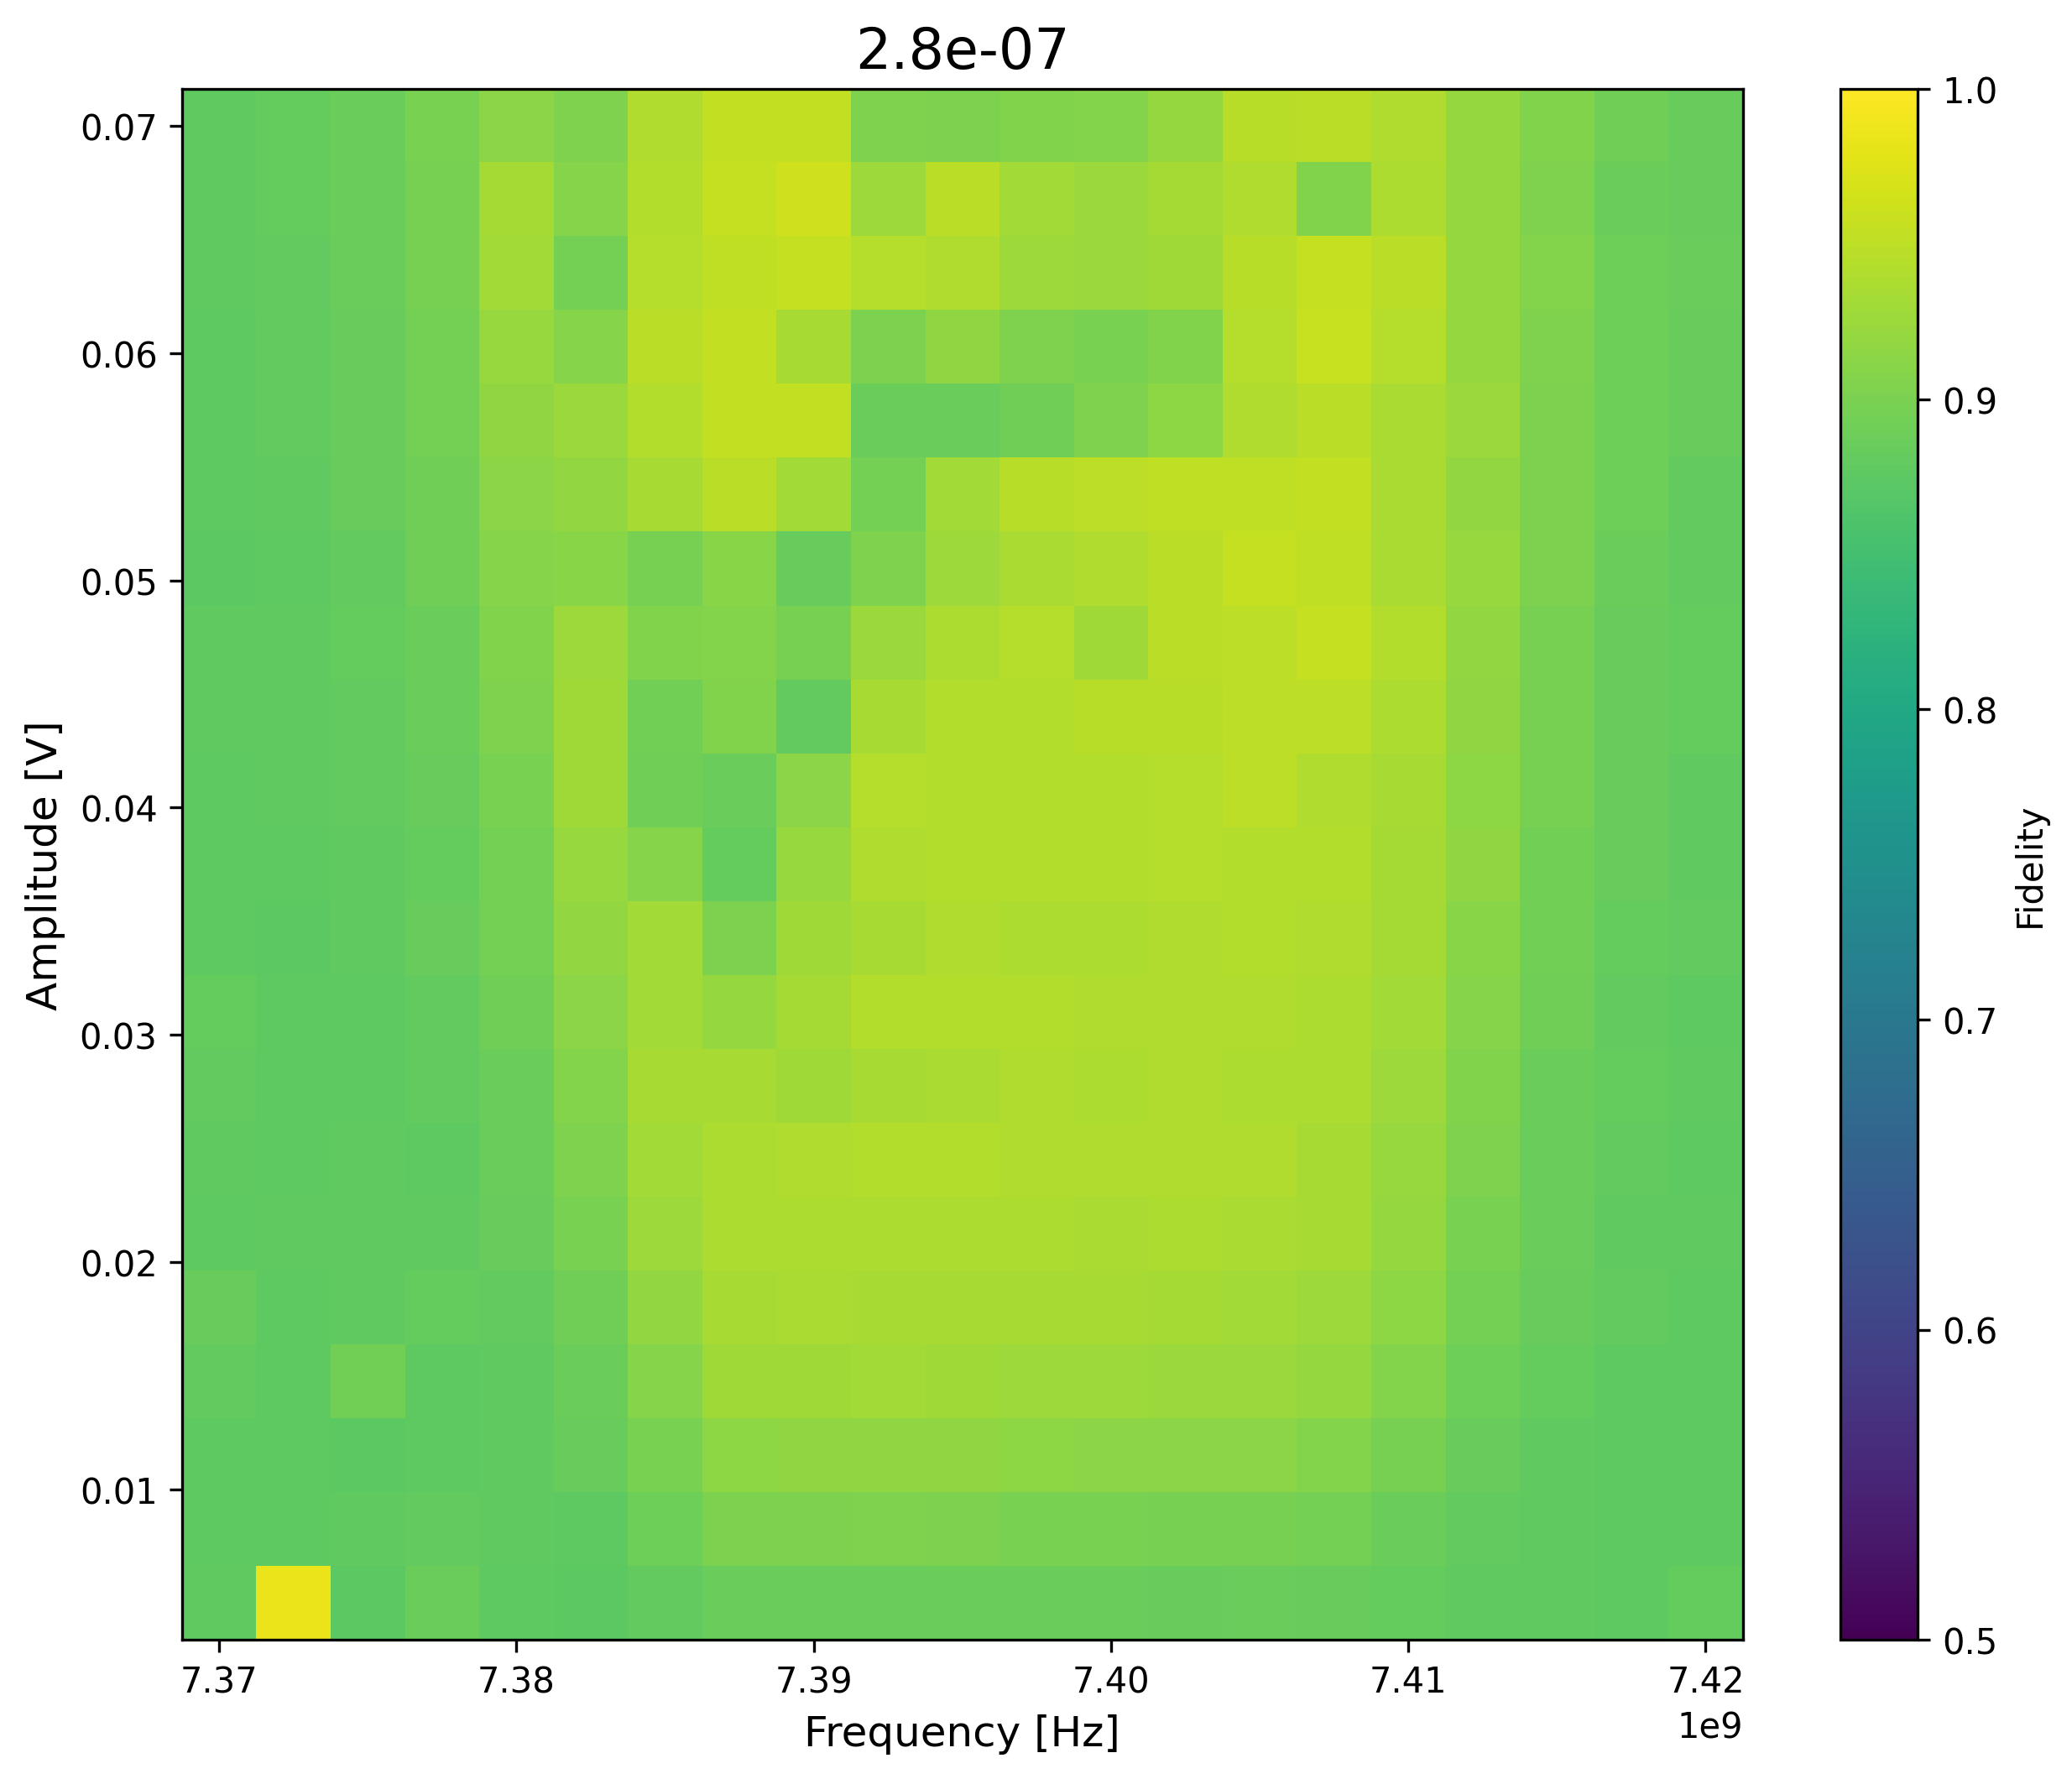

In [31]:
plotSingleFidelity(frequency,amplitude,transition_fidelity, str(duration))

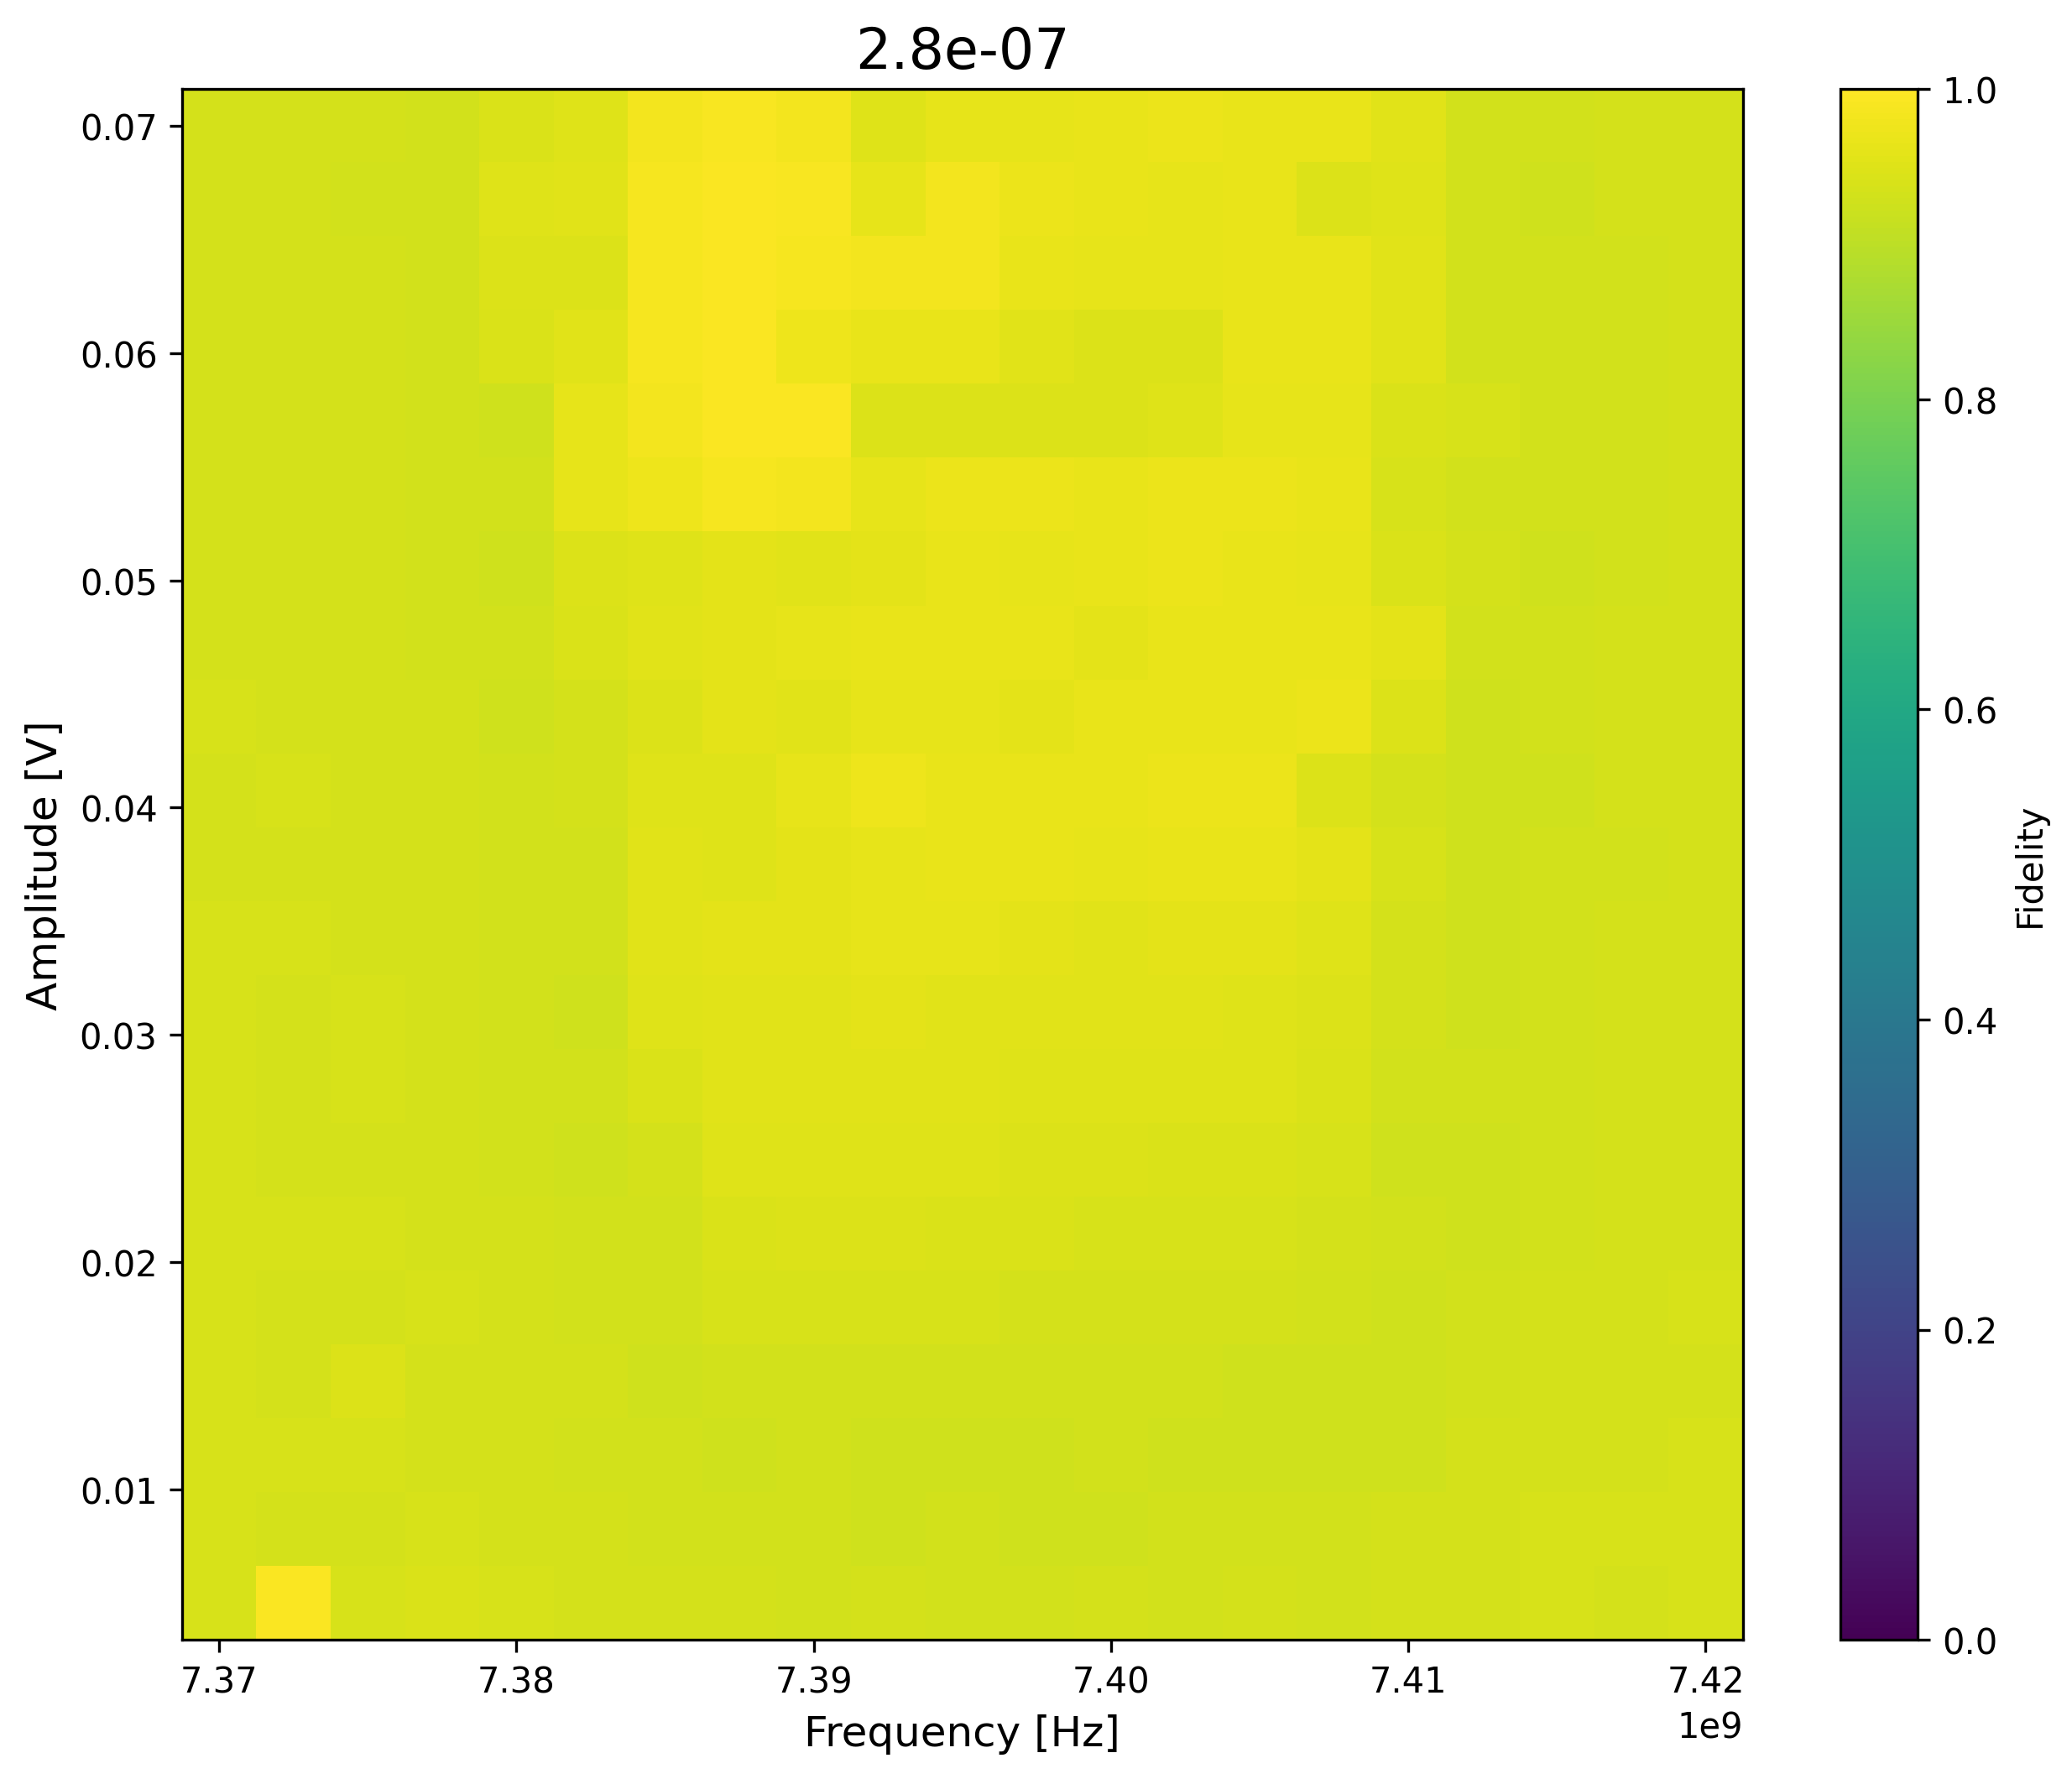

In [27]:
plotSingleFidelity(frequency,amplitude,assignment_fidelity, str(duration))

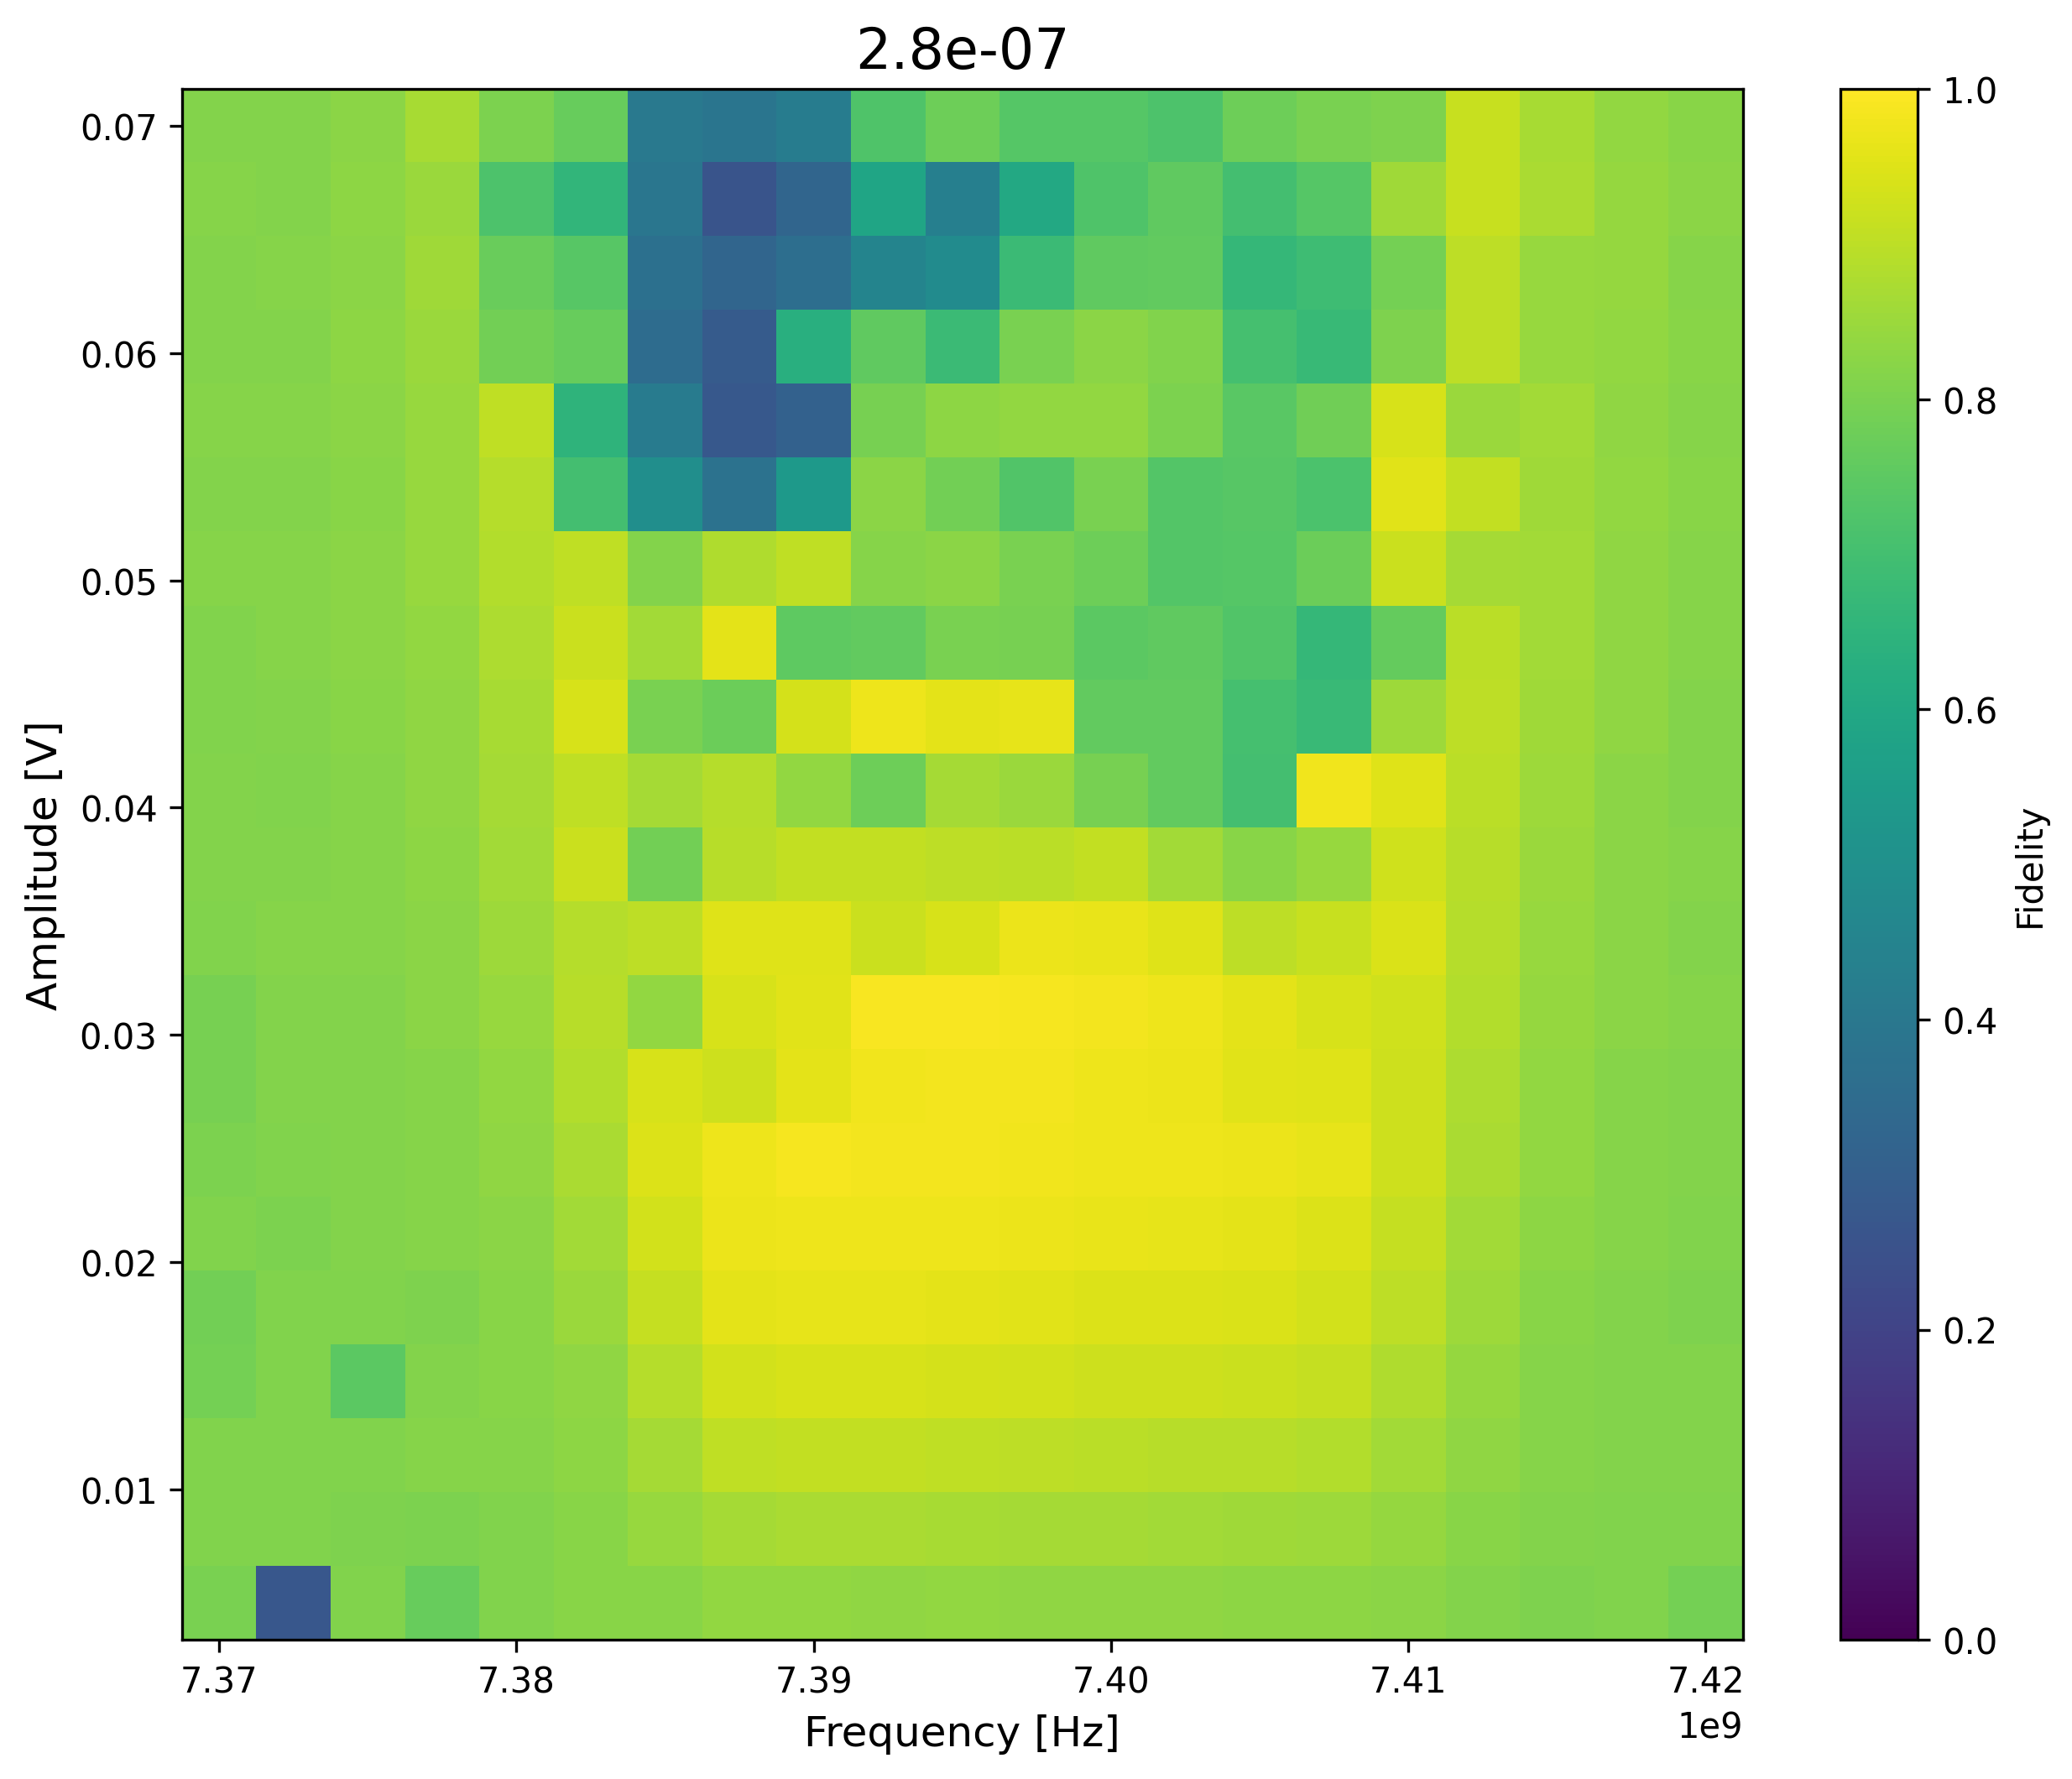

In [28]:
plotSingleFidelity(frequency,amplitude,leakage_fidelity, str(duration))

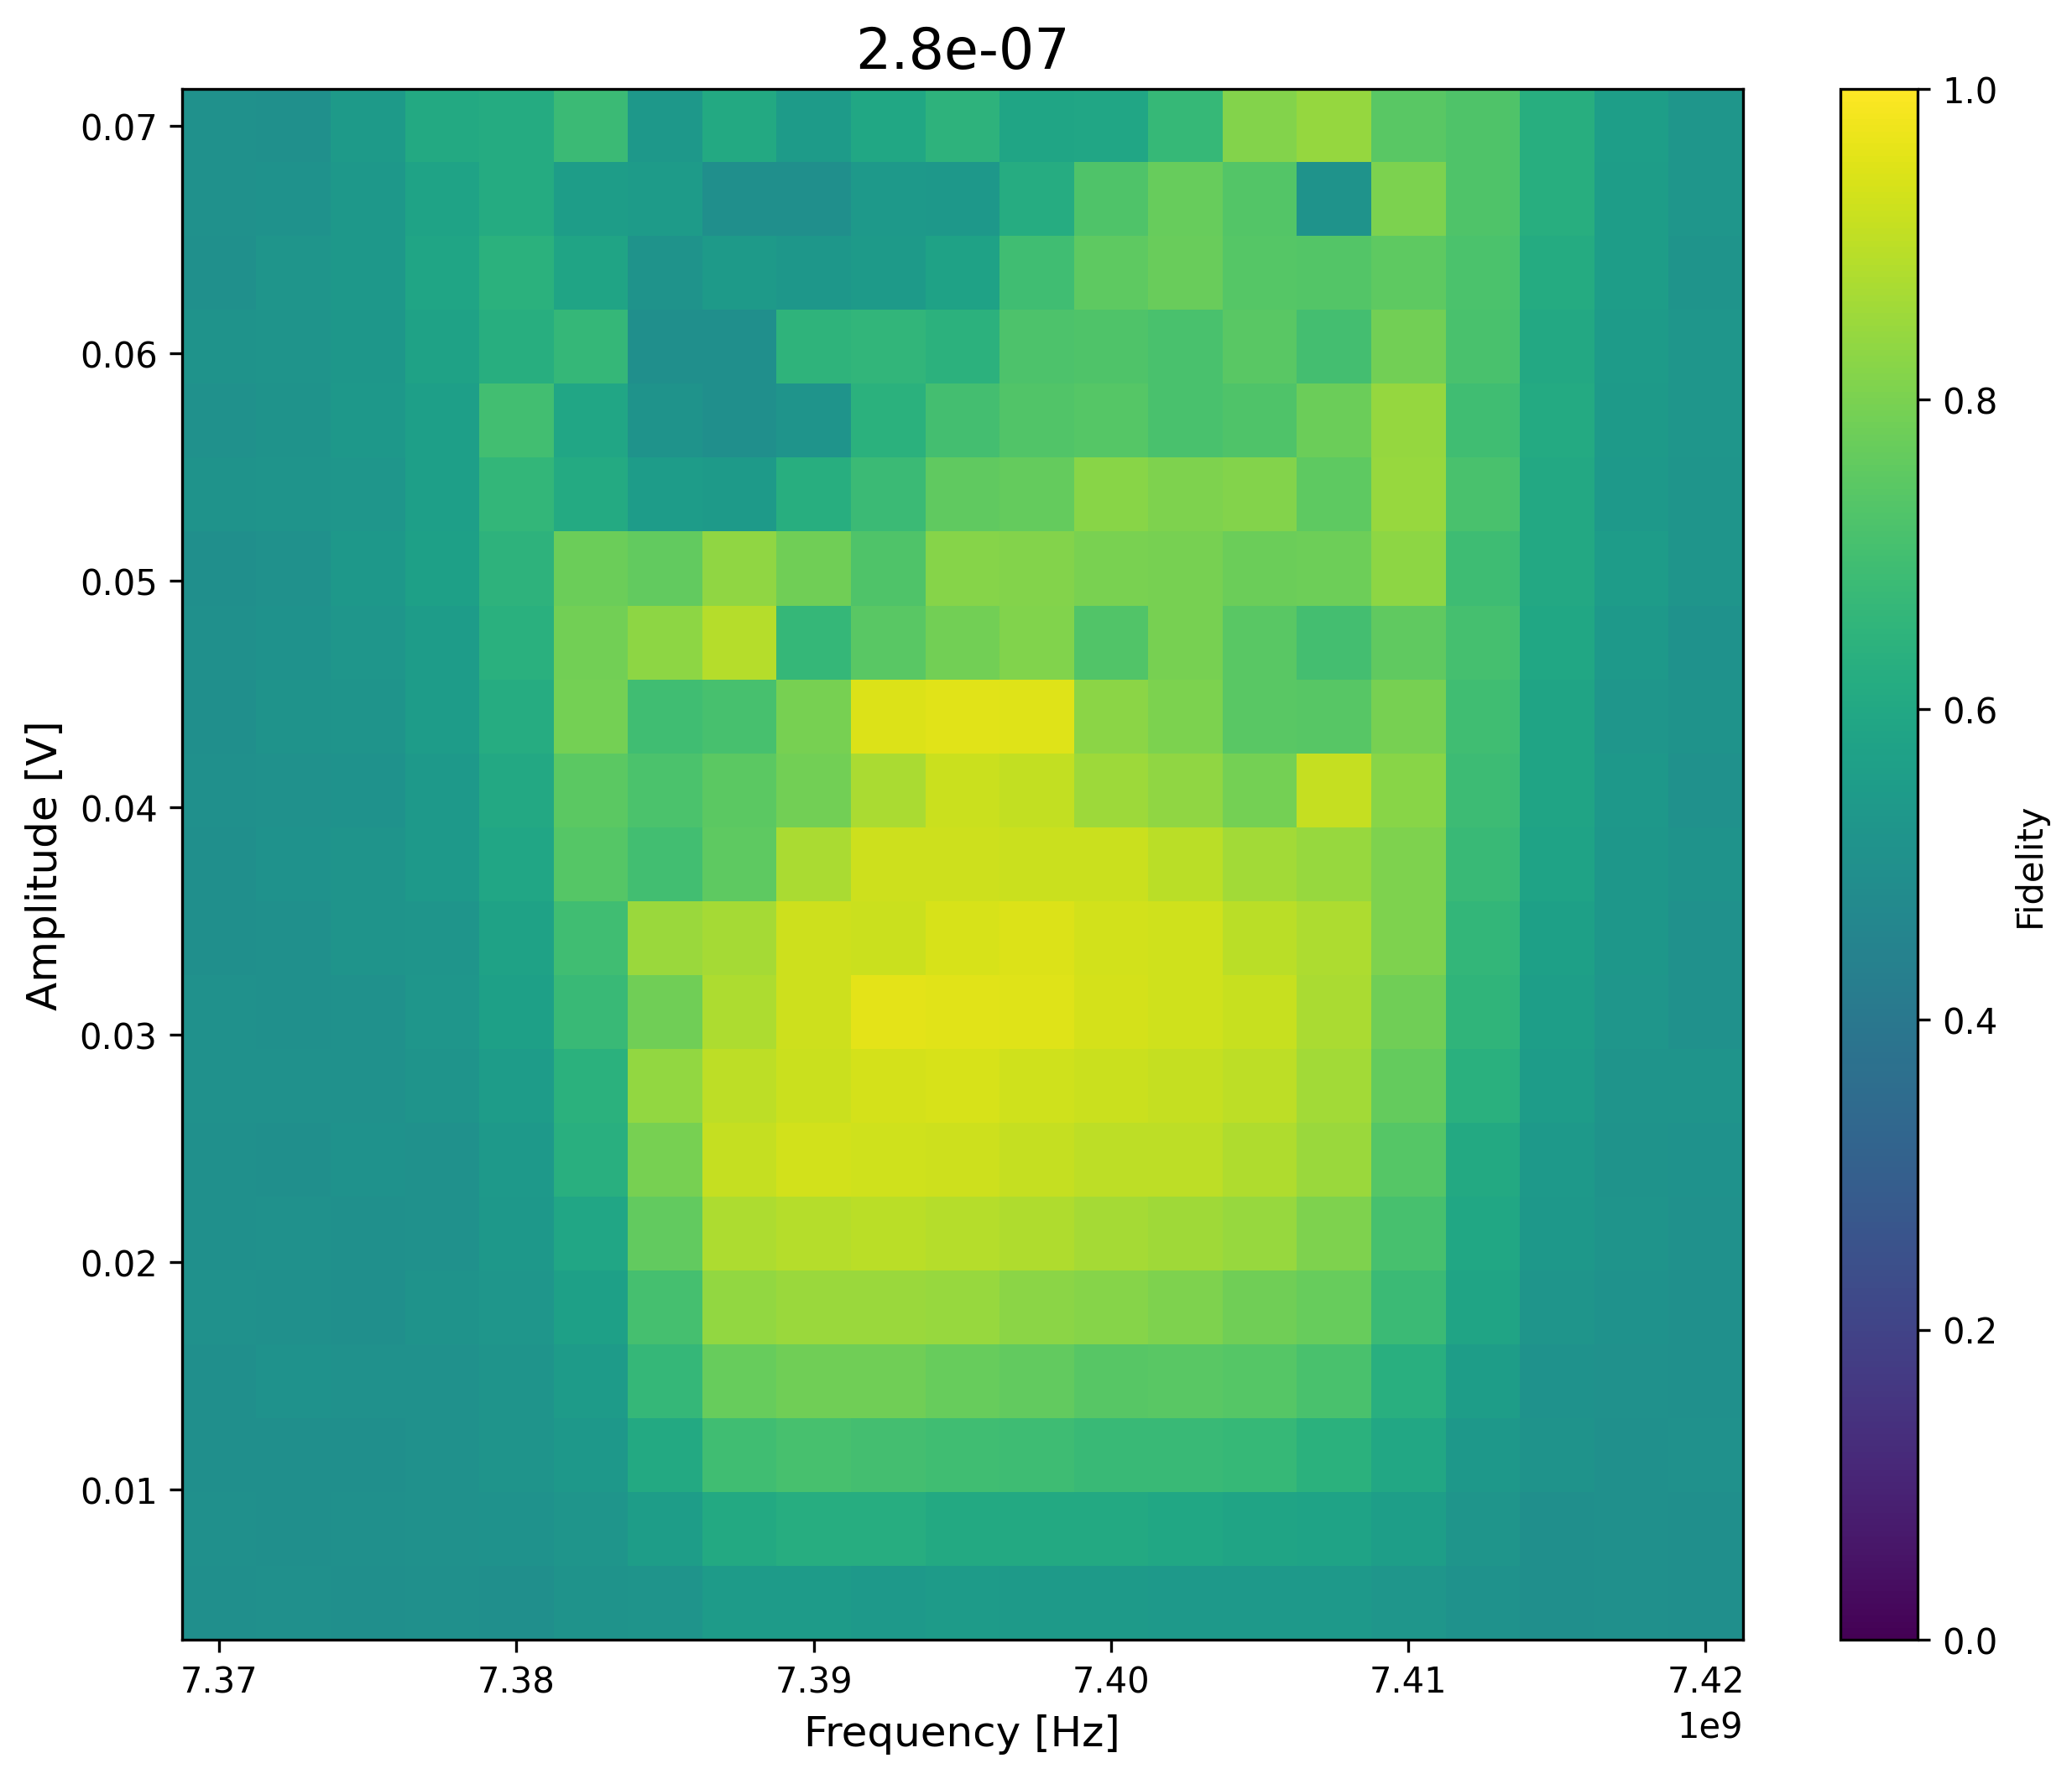

In [29]:
plotSingleFidelity(frequency, amplitude, qnd_pi_fidelity, str(duration))

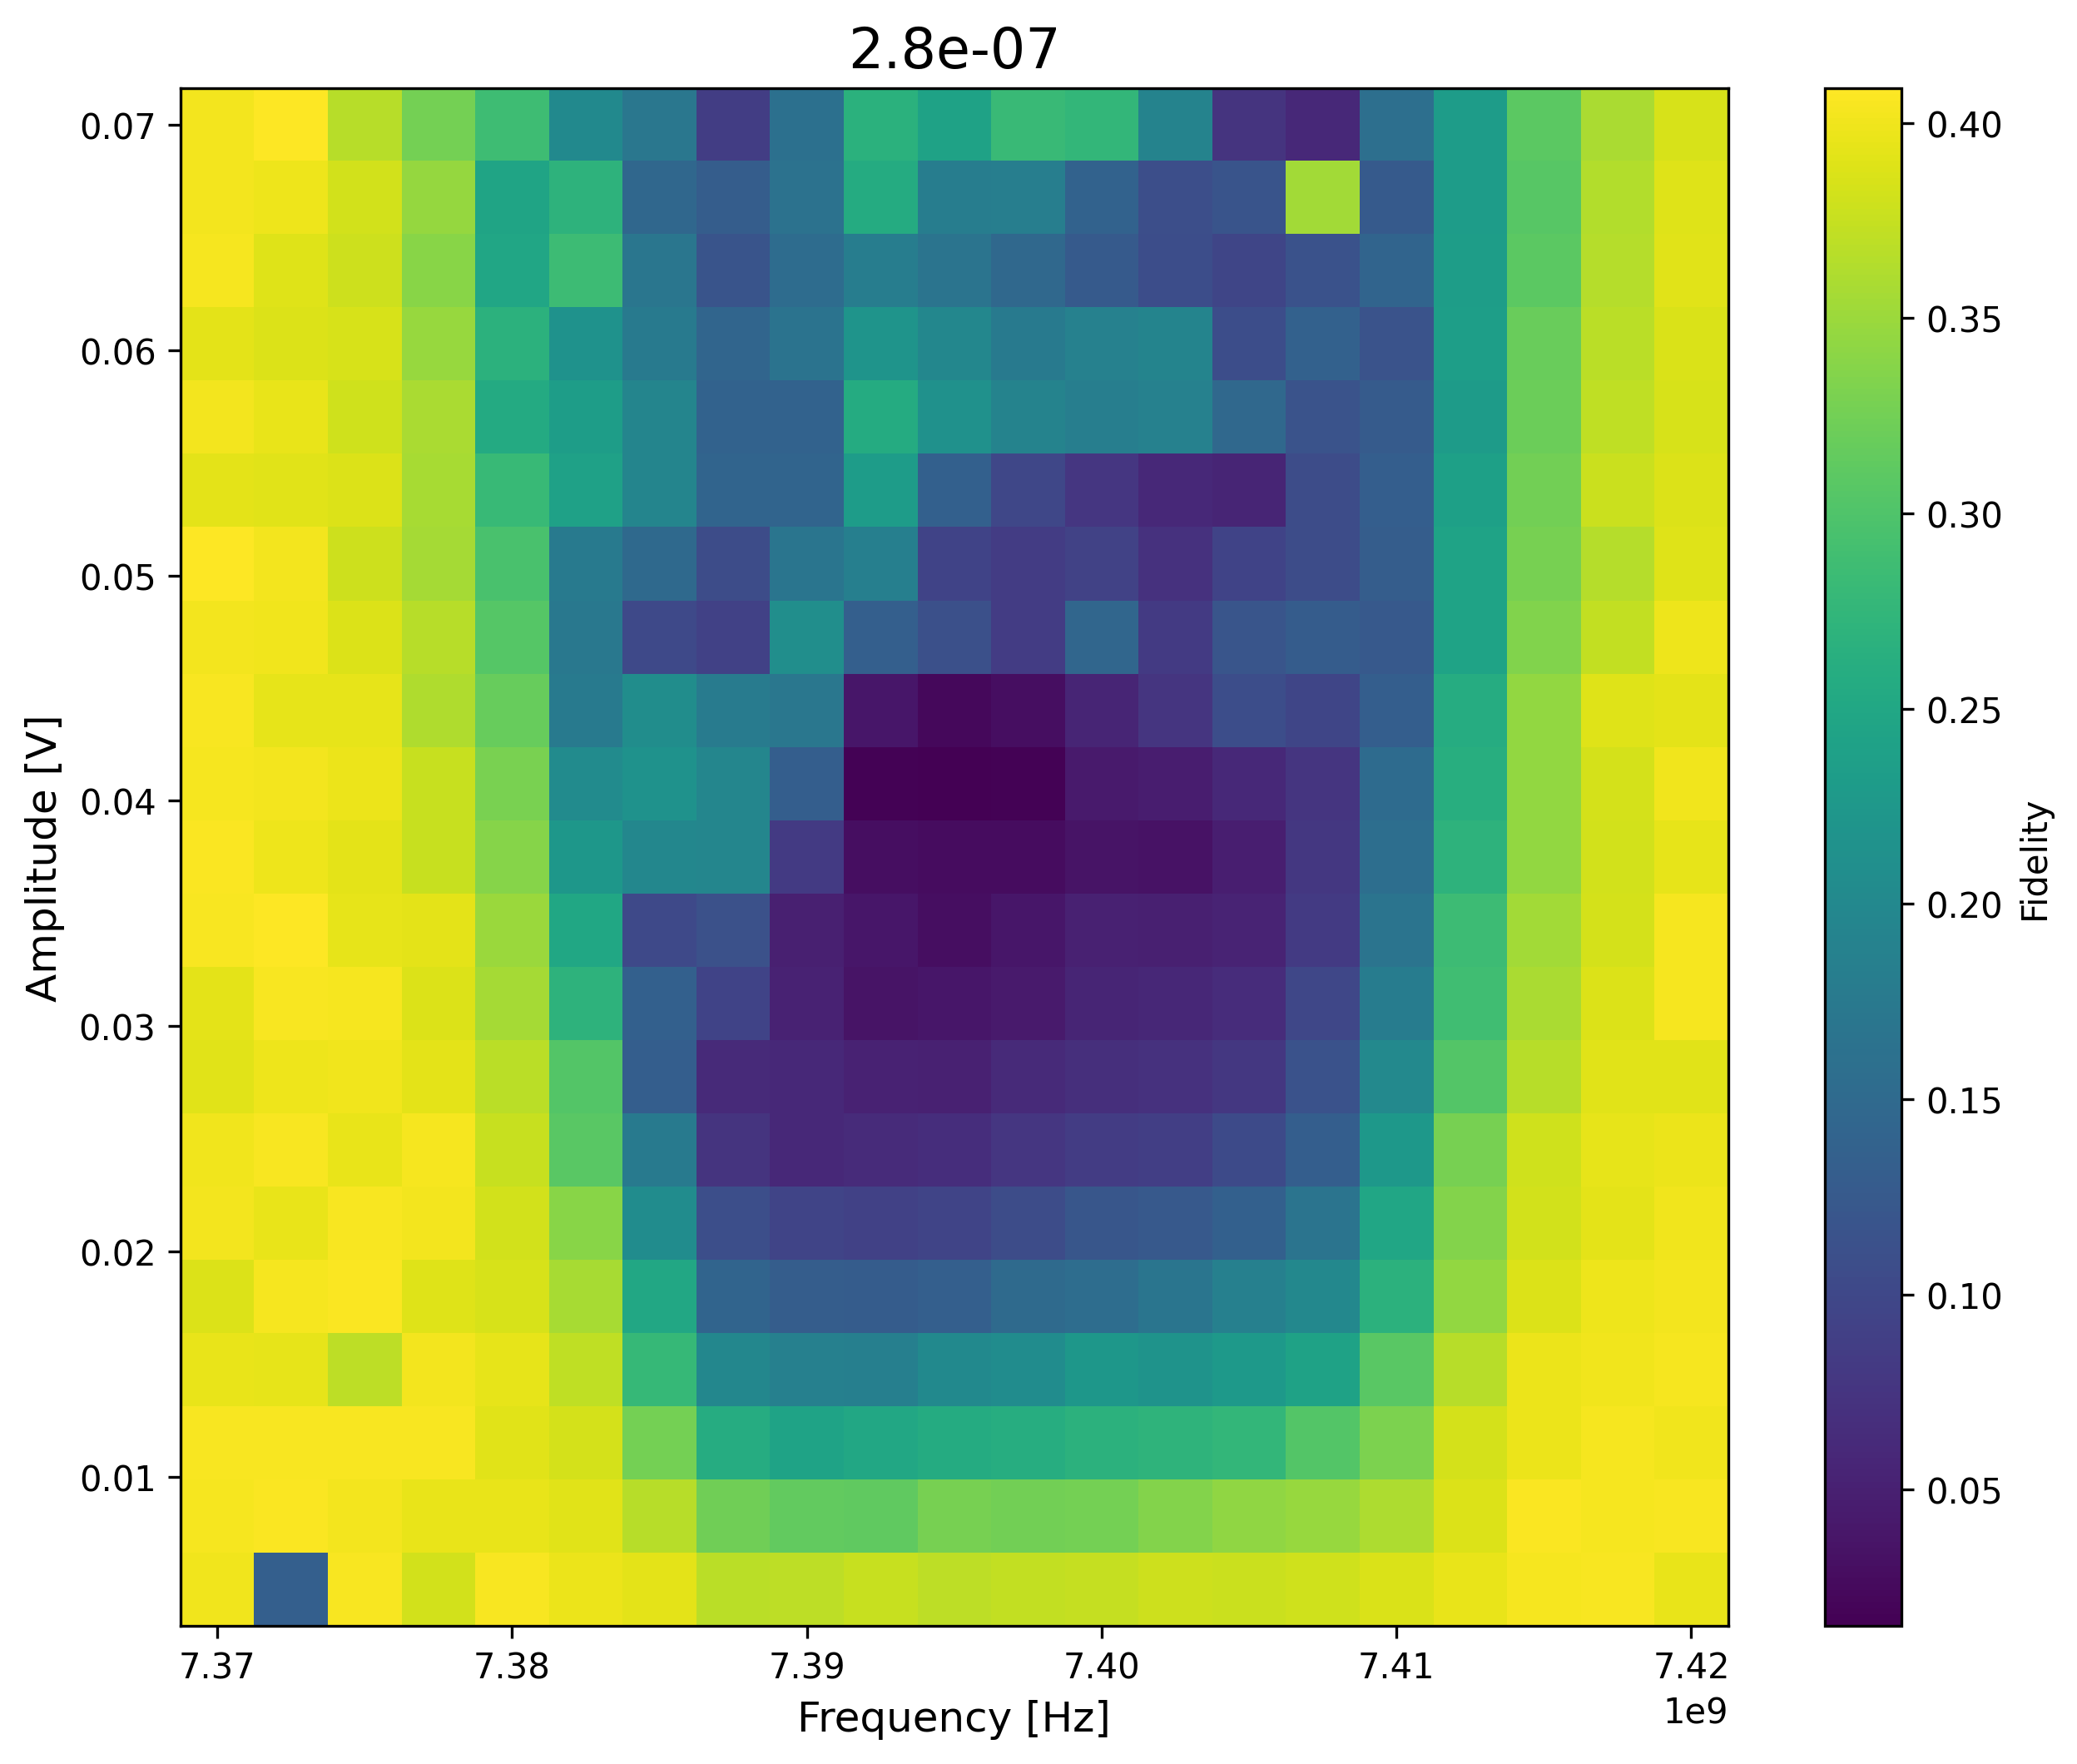

In [35]:
plotSingleFidelity(frequency, amplitude, np.abs(qnd_pi_fidelity-(leakage_fidelity/2+0.5)), str(duration))

In [38]:
print(np.min(qnd_pi_fidelity),",", np.max(qnd_pi_fidelity))
print(np.min(leakage_fidelity),",", np.max(leakage_fidelity))


0.5 , 0.9605305806424178
0.2610316854014333 , 0.9916421113900106
